## In this notebook

- Look at the provided data for the first time.
- Overall goal of the task: Predict electronic vehicles charging stations availability in Paris.
- There are four target columns:
    - `Available`: how many plugs are available at time t for the station k,
    - `Charging`: how many plugs are occupied and charging at time t for the station k,
    - `Passive`: how many plugs are occupied but not charging at time t for the station k,
    - `Other`: how many plugs are either offline or out of order at time t for the station k.

In [1]:
import os

# analytics
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import numpy as np

# plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
DATA_FOLDER = "../data"

TARGETS = ["Available", "Charging", "Passive", "Other"]

In [4]:
! ls -l $DATA_FOLDER

total 181500
-rw-rw-r-- 1 nobody nogroup  14095077 Aug  4 08:41 test.csv
-rw-rw-r-- 1 nobody nogroup 171754453 Aug  4 08:41 train.csv


## Load data

In [5]:
# load train data

df = pd.read_csv(os.path.join(DATA_FOLDER, "train.csv"))
df = df.sort_values(by=["Station", "date"]).reset_index(drop=True)
df.tail()

,date,Station,Available,Charging,Passive,Other,tod,dow,trend,Latitude,Longitude,Postcode,area
1851078,2021-02-18 22:45:00,FR*V75*EBELI*99*1,2,0,1,0,91,5,22198,48.8778,2.39182,75019,east
1851079,2021-02-18 23:00:00,FR*V75*EBELI*99*1,3,0,0,0,92,5,22199,48.8778,2.39182,75019,east
1851080,2021-02-18 23:15:00,FR*V75*EBELI*99*1,3,0,0,0,93,5,22200,48.8778,2.39182,75019,east
1851081,2021-02-18 23:30:00,FR*V75*EBELI*99*1,3,0,0,0,94,5,22201,48.8778,2.39182,75019,east
1851082,2021-02-18 23:45:00,FR*V75*EBELI*99*1,3,0,0,0,95,5,22202,48.8778,2.39182,75019,east


## Check data quality

In [6]:
print(f"Number of stations: {df.Station.nunique()}")

Number of stations: 91


In [7]:
# there are missing data in the series

df_stations_stats = (
    df
    .groupby("Station")
    .date
    .agg(["count", "min", "max"])
)

df_stations_stats.head()

,count,min,max
Station,,,
FR*V75*EBELI*1*1,16878,2020-07-03 00:00:00,2021-02-18 23:45:00
FR*V75*EBELI*10*1,22103,2020-07-03 00:00:00,2021-02-18 23:45:00
FR*V75*EBELI*11*1,21349,2020-07-03 00:00:00,2021-02-18 23:45:00
FR*V75*EBELI*12*1,22052,2020-07-03 00:00:00,2021-02-18 23:45:00
FR*V75*EBELI*13*1,21867,2020-07-03 00:00:00,2021-02-18 23:45:00


In [8]:
# only one station (out of 91) has all the data points filled

DATA_POINTS_PER_DAY = 4 * 24

min_timestamp = pd.to_datetime(df_stations_stats["min"].min())
max_timestamp = pd.to_datetime(df_stations_stats["max"].max())

df_stations_stats[
    df_stations_stats["count"] == ((max_timestamp - min_timestamp).days * DATA_POINTS_PER_DAY)
]

,count,min,max
Station,,,
FR*V75*EBELI*89*1,22080,2020-07-03 00:00:00,2021-02-18 23:45:00


In [9]:
# sum of all plugs is always equal to three

assert (df[TARGETS].sum(axis=1) == 3).all()

In [10]:
# there are no missing values

df.isnull().sum()

date         0
Station      0
Available    0
Charging     0
Passive      0
Other        0
tod          0
dow          0
trend        0
Latitude     0
Longitude    0
Postcode     0
area         0
dtype: int64

## Check predictors distributions

In [11]:
for col in ["dow", "Postcode", "area"]:
    print(f"- col: {col}")
    print(
        df[col].value_counts()
    )
    print()

- col: dow
4    268053
5    266201
1    265096
7    264074
3    263661
2    263558
6    260440
Name: dow, dtype: int64

- col: Postcode
75016    173521
75013    164650
75012    153473
75007    144444
75019    132762
75015    125406
75017    122168
75018    109116
75020     99815
75014     85168
75008     82524
75010     64515
75005     64017
75004     60065
75006     59117
75011     46565
75002     44203
75001     40909
75003     34669
75116     22109
75009     21867
Name: Postcode, dtype: int64

- col: area
east     497130
west     465480
north    455456
south    433017
Name: area, dtype: int64



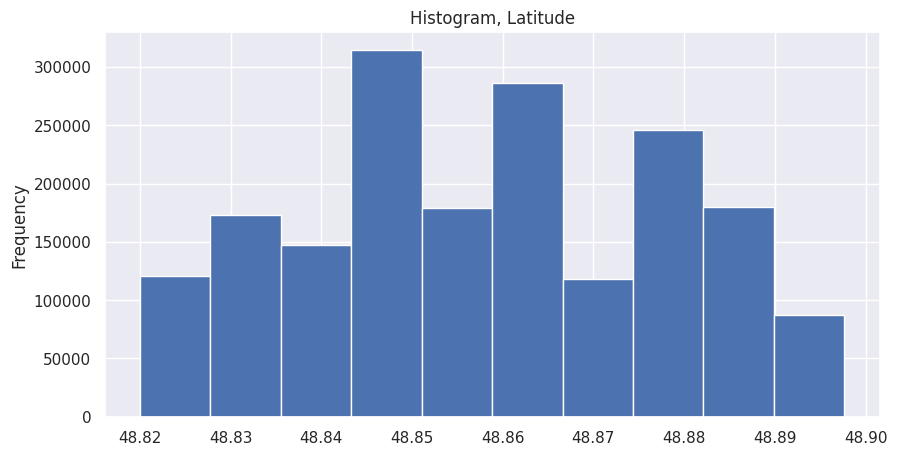

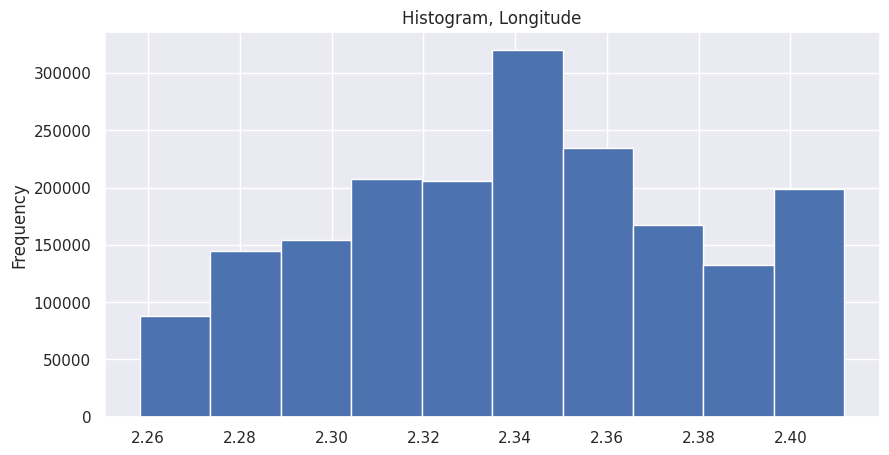

In [12]:
for col in ["Latitude", "Longitude"]:
    (
        df[col]
        .plot(kind="hist", title=f"Histogram, {col}")
    )
    
    plt.show()

## Check targets distributions

In [13]:
for col in TARGETS:
    print(f"- col: {col}")
    print(
        df[col].value_counts()
    )
    print()

- col: Available
3    704870
2    510109
0    416100
1    220004
Name: Available, dtype: int64

- col: Charging
0    1456836
1     320708
2      68332
3       5207
Name: Charging, dtype: int64

- col: Passive
0    1465372
1     300554
2      68296
3      16861
Name: Passive, dtype: int64

- col: Other
0    1370099
3     366672
1      90945
2      23367
Name: Other, dtype: int64



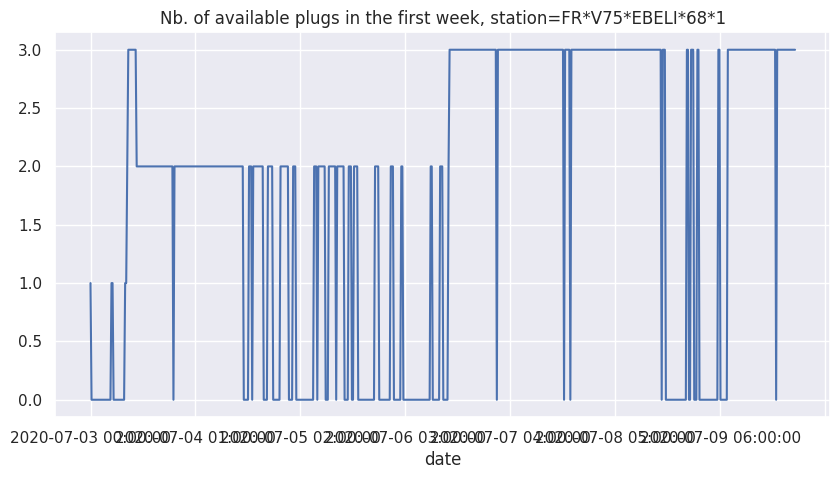

In [14]:
# plot one week of 

station = np.random.choice(df.Station.unique())
# station = "FR*V75*EBELI*89*1"

ax = (
    df
    .loc[df.Station == station]
    .set_index("date")
    .Available
    .head(96 * 7)
    .plot(
        title=f"Nb. of available plugs in the first week, station={station}"
    )
)

## Results

- The data are not in the best shape.
    - Only one station (out of 91) has all the data points filled.
    - It seems that plugs availability data are very random.